<a href="https://colab.research.google.com/github/soyudea/StrokePredictionModel/blob/main/04_modelo_con_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import math
from seaborn import distplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from matplotlib.patches import split_path_inout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score

**1. Cargar Dataset**

Se carga el dataset final luego del preprocesamiento. Se cargan los archivos Dataset.csv y y.csv

In [4]:
X = pd.read_csv('Dataset.csv', sep=",") 
y = pd.read_csv('y.csv', sep=",") 

X=X.drop(columns=['Unnamed: 0'])
y=y.drop(columns=['Unnamed: 0'])


**2. Generador de muestras sintéticas**

In [5]:
pca=PCA(n_components=30) 
pca.fit(X) #
X_pca=pca.transform(X)

In [6]:
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)                          
Xres, yres = ros.fit_resample(X_pca, y)
Xtrain, Xtst, ytrain, ytst = train_test_split(Xres,yres, test_size=0.1) #Se toma el 90 % de los datos para Entrenar
print (Xtrain.shape, ytrain.shape, Xtst.shape, ytst.shape)
X=Xtrain
y=ytrain

(26409, 30) (26409, 1) (2935, 30) (2935, 1)


**3. Cálculo pesos de la clase Parámetro que se usa para minimizar el efecto del desbalance del dataset**

In [7]:
def dar_peso_clase():
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 17)
  Number_Muestras_por_Clase = ytrain.value_counts()
  Number_Muestras_por_Clase = Number_Muestras_por_Clase.sort_index(axis = 0, ascending = True)
  Numero_de_Clases = len(Number_Muestras_por_Clase.index)
  Peso_por_Clase = len(ytrain)/(Numero_de_Clases*Number_Muestras_por_Clase)
  return Peso_por_Clase

**4. Modelo de clasificación random Forest Entrenamiento con el 90 % de los datos**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [8]:
weight = dar_peso_clase() 
kf = KFokf = KFold(n_splits=10, random_state = True,shuffle=True)

X_test =0
Y_test =0

#warm_start mejoro la velocidad de ejecucion, mejoró la metrica
classifier = RandomForestClassifier(min_samples_split=10,
                                    ccp_alpha=0.000001,
                                    criterion='gini',
                                    class_weight = {0: weight[0], 1: weight[1]},
                                    random_state=True,max_features ="sqrt",
                                    warm_start=True,min_impurity_decrease=0.000005)

for train_index, test_index in kf.split(X):
    
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    modelo = classifier.fit(Xtrain, ytrain)
    ypred = modelo.predict(Xtest)

    print()
    print(confusion_matrix(ytest, ypred))
    print(classification_report(ytest, ypred, digits =4, labels=[0,1]))
    s = roc_auc_score(ytest, modelo.predict(Xtest))
    print(f'Best val auc: {s: .4f}')

<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)



[[ 922  382]
 [ 117 1220]]
              precision    recall  f1-score   support

           0     0.8874    0.7071    0.7870      1304
           1     0.7615    0.9125    0.8302      1337

    accuracy                         0.8111      2641
   macro avg     0.8245    0.8098    0.8086      2641
weighted avg     0.8237    0.8111    0.8089      2641

Best val auc:  0.8098

[[ 937  402]
 [ 117 1185]]
              precision    recall  f1-score   support

           0     0.8890    0.6998    0.7831      1339
           1     0.7467    0.9101    0.8204      1302

    accuracy                         0.8035      2641
   macro avg     0.8178    0.8050    0.8017      2641
weighted avg     0.8188    0.8035    0.8015      2641



<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Best val auc:  0.8050

[[ 926  364]
 [ 120 1231]]
              precision    recall  f1-score   support

           0     0.8853    0.7178    0.7928      1290
           1     0.7718    0.9112    0.8357      1351

    accuracy                         0.8167      2641
   macro avg     0.8285    0.8145    0.8143      2641
weighted avg     0.8272    0.8167    0.8148      2641

Best val auc:  0.8145

[[ 913  399]
 [ 109 1220]]
              precision    recall  f1-score   support

           0     0.8933    0.6959    0.7823      1312
           1     0.7536    0.9180    0.8277      1329

    accuracy                         0.8076      2641
   macro avg     0.8234    0.8069    0.8050      2641
weighted avg     0.8230    0.8076    0.8052      2641



<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Best val auc:  0.8069

[[ 922  360]
 [ 136 1223]]
              precision    recall  f1-score   support

           0     0.8715    0.7192    0.7880      1282
           1     0.7726    0.8999    0.8314      1359

    accuracy                         0.8122      2641
   macro avg     0.8220    0.8096    0.8097      2641
weighted avg     0.8206    0.8122    0.8104      2641



<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Best val auc:  0.8096

[[ 978  365]
 [ 130 1168]]
              precision    recall  f1-score   support

           0     0.8827    0.7282    0.7980      1343
           1     0.7619    0.8998    0.8252      1298

    accuracy                         0.8126      2641
   macro avg     0.8223    0.8140    0.8116      2641
weighted avg     0.8233    0.8126    0.8114      2641

Best val auc:  0.8140


<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo


[[ 961  376]
 [ 122 1182]]
              precision    recall  f1-score   support

           0     0.8873    0.7188    0.7942      1337
           1     0.7587    0.9064    0.8260      1304

    accuracy                         0.8114      2641
   macro avg     0.8230    0.8126    0.8101      2641
weighted avg     0.8238    0.8114    0.8099      2641

Best val auc:  0.8126

[[ 982  372]
 [  95 1192]]
              precision    recall  f1-score   support

           0     0.9118    0.7253    0.8079      1354
           1     0.7621    0.9262    0.8362      1287

    accuracy                         0.8232      2641
   macro avg     0.8370    0.8257    0.8220      2641
weighted avg     0.8389    0.8232    0.8217      2641

Best val auc:  0.8257

[[ 927  363]
 [ 114 1237]]
              precision    recall  f1-score   support

           0     0.8905    0.7186    0.7954      1290
           1     0.7731    0.9156    0.8384      1351

    accuracy                         0.8194      2641


<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(



[[ 964  382]
 [ 110 1184]]
              precision    recall  f1-score   support

           0     0.8976    0.7162    0.7967      1346
           1     0.7561    0.9150    0.8280      1294

    accuracy                         0.8136      2640
   macro avg     0.8268    0.8156    0.8123      2640
weighted avg     0.8282    0.8136    0.8120      2640

Best val auc:  0.8156


**5. Curva ROC: RandomForest**


Sin entrenar: ROC AUC=0.500
Algoritmo RandomForest: ROC AUC=0.816




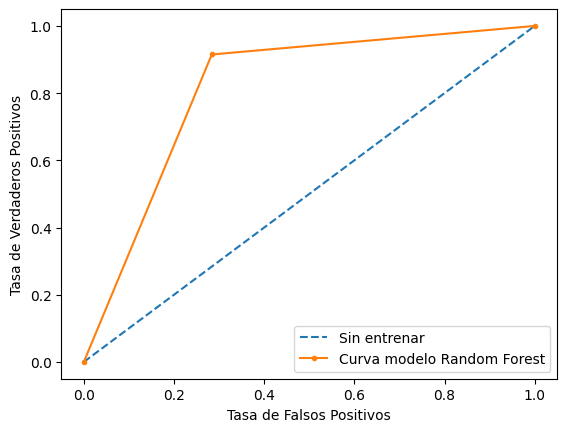

In [9]:
classes = classifier.predict(Xtest)
ns_probs = [0 for _ in range(len(ytest))]
ns_auc = roc_auc_score(ytest, ns_probs,average='weighted')
classifier_auc = roc_auc_score(ytest,classes,average='weighted')
#aps = average_precision_score(ytest, ns_probs)
print()
#print("Average_presicion_score "+str(aps))
print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Algoritmo RandomForest: ROC AUC=%.3f' % (classifier_auc))
print()
classifier_probs = classes[:]
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
classifier_fpr,classifier_tpr, _ = roc_curve(ytest, classifier_probs)
print()
pyplot.plot(classifier_fpr,classifier_tpr, marker='.', label='Curva modelo Random Forest')
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()